# 2D BCSD Crack inverse problem example (2DP1)

Instead of just one collocation point per element like in the case of the 2DP0 kernel, the 2DP1 kernel has 2 collocation points.

As before, the traction boundary conditions are specified as follows,
$$
t(x) =
    \begin{cases}
        -\sigma_A & \text{if } x \leq |a|\\
        \tau_F-\sigma_A & \text{if } |c| \geq x > |a|
    \end{cases}
$$

Then, the analytical displacement solution for the BCSD crack is given as seen in Weertman (1996), 
$$
D(x) = {2 (1-\nu) \tau_F \over \pi G} \{ x \ln \big| {x\sqrt{c^2 - a^2} + a\sqrt{c^2 - x^2} \over x\sqrt{c^2 - a^2} - a\sqrt{c^2 - x^2}} \big| - a \ln \big| {\sqrt{c^2 - a^2} + \sqrt{c^2 - x^2} \over \sqrt{c^2 - a^2} - \sqrt{c^2 - x^2}} \big| \}
$$

In [7]:
import numpy as np
import sys
import os
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
from scipy.sparse.linalg import gmres

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
#plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

home = os.environ['HOME'] 
# sys.path.append(home + "/geolab/dev_bigwham/build/interfaces/python")
# from bigwham4py import Hmatrix  # linear operator file

sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file

In [8]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
alpha = 1 - nu

tau_F = 1.0
sigma_A = (2 * tau_F)/3

ct_pressure = - sigma_A
pz_pressure = tau_F - sigma_A

pre_fac = - 2 * ((alpha*tau_F) / (np.pi*G))

a = 1.0
pz_fac = 1 / (np.cos((np.pi*sigma_A)/(2*tau_F)))
c = 2*a

#plastic zone formula
#pz_fac_2 = 1 + 2*pz_fac*np.sin((np.pi*sigma_A)/(4*tau_F))**2
#c_2 = a*pz_fac_2

# Mesh
nelts = 100
coor1D = np.linspace(-c, c, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

# H-matrix parameters
max_leaf_size = 100
eta = 3.
eps_aca = 1.e-4

# Hmatrix
kernel = "2DP1"
elas_prop = np.array([E, nu])
hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

col_pts = hmat.getMeshCollocationPoints()

 Now setting things for kernel ... 2DP1 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  2.295e-06
Binary cluster tree depth = 1
Number of blocks = 4
Number of full blocks = 4
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.0119458
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED


In [9]:
trac = np.zeros(col_pts.shape)
trac[:, 1] = ct_pressure
for i in range(len(trac)):
    if abs(col_pts[i][0])>=a:
        trac[i][1] = pz_pressure
#print(trac)

u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
dd_calc = hmat.convert_to_global(u)

Pressure between x = - 1.0  and + 1.0 is =  -0.6666666666666666
Pressure between |x| =  1.0  and  2.0  is =  0.33333333333333337


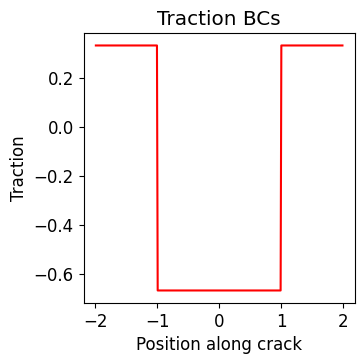

In [10]:
plt.figure()
plt.plot(col_pts[:, 0], trac[:, 1], color='r')
plt.title("Traction BCs")
plt.xlabel("Position along crack")
plt.ylabel("Traction")
print("Pressure between x = -", a , " and +", a , "is = ", ct_pressure)
print("Pressure between |x| = ", a , " and ", c , " is = ", pz_pressure)

Text(0, 0.5, 'Displacement')

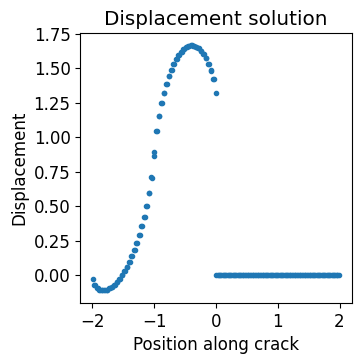

In [11]:
info
dd_calc_norm = dd_calc/(a*pre_fac)
plt.figure()
plt.plot(col_pts[:, 0], dd_calc_norm.reshape(-1, 2)[:, 1], ".")

plt.title("Displacement solution")
plt.xlabel("Position along crack")
plt.ylabel("Displacement")

In [69]:
nelts_array = [10**i for i in range(5)]
rel_err_array = []

for nelts in nelts_array:
    # Mesh
    coor1D = np.linspace(-c, c, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

    # H-matrix parameters
    max_leaf_size = 100
    eta = 3.
    eps_aca = 1.e-4

    # Hmatrix
    kernel = "2DP0"
    elas_prop = np.array([E, nu])
    hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

    col_pts = hmat.getMeshCollocationPoints()

    trac = np.zeros(col_pts.shape)
    trac[:, 1] = ct_pressure
    for i in range(len(trac)):
        if abs(col_pts[i][0])>=a:
            trac[i][1] = pz_pressure
    #print(trac)

    u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
    dd_calc = hmat.convert_to_global(u)

    dd_calc_norm = dd_calc/(a*pre_fac)

    dd = np.zeros(col_pts.shape)
    pzl2 = np.sqrt(c**2 - a**2)
    x_pzl2 = col_pts[:, 0]*pzl2
    ctzl2 = np.sqrt(c**2 - col_pts[:, 0]**2)
    a_ctzl2 = a*ctzl2

    dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))

    rel_err = np.linalg.norm(dd.flatten() - dd_calc_norm) / dd.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_err_array.append(rel_err)

    '''
    info
    dd_calc_norm = dd_calc/(a*pre_fac)
    plt.figure()
    #plt.plot(np.linalg.norm(col_pts, axis=1), dd_calc.reshape(-1, 2), ".k")
    plt.plot(col_pts[:, 0], dd_calc_norm.reshape(-1, 2)[:, 1], ".")
    plt.plot(col_pts[:, 0], dd.reshape(-1, 2)[:, 1], ".")
    #plt.ylim([-0.01, 0.01])
    '''

 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  2.8e-07
Binary cluster tree depth = 0
Number of blocks = 1
Number of full blocks = 1
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 8.5632e-05
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED
L2 Rel error 2.134553508226038
 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  1.64e-07
Binary cluster tree depth = 0
Number of blocks = 1
Number of full blocks = 1
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat 

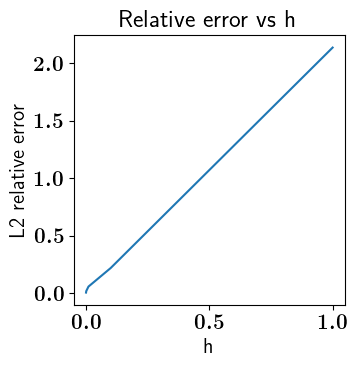

In [74]:
h_array = [1/nelts for nelts in nelts_array]

plt.figure()
plt.plot(h_array, rel_err_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

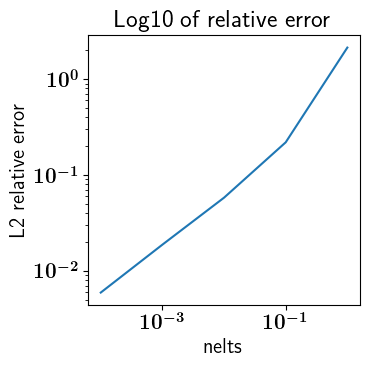

In [76]:
plt.figure()
plt.plot(h_array, rel_err_array)
plt.title("Log10 of relative error")
plt.xlabel("nelts")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [80]:
print(h_array)
print(rel_err_array)

log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_err_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

[1.0, 0.1, 0.01, 0.001, 0.0001]
[2.134553508226038, 0.21916459565302446, 0.058009800118891876, 0.018763278692101575, 0.005933421862324179]
0.4950980707819062
-0.5633673830410317


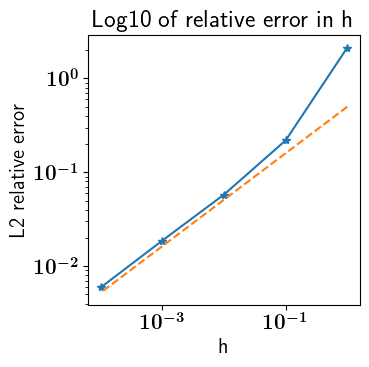

In [79]:
plt.figure()
plt.plot(h_array, rel_err_array, "*-")
plt.plot(h_array, 0.5*np.array(h_array) ** (m) , "--")
plt.title("Log10 of relative error in h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
#saves fig - remember to remove
# plt.savefig('log2_rel_err_h.png', dpi=100, bbox_inches='tight')
# plt.show()